In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [29]:
df = pd.read_csv("data/daily_timeseries_parking_violations_v2.csv")

# Create lag features (lag 1 is # of violations from 1 day ago, lag 2 is # violations from 2 days ago, and lag 3 is from 3 days)
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['num_violations'].shift(lag)

# 7 day forecast targets
for step in range(1, 8):
    df[f'target_t+{step}'] = df['num_violations'].shift(-step)

# Drop rows without lag features or forecast target days
df = df.dropna().reset_index(drop=True)

df['is_holiday'] = df['is_holiday'].astype(str)
df['is_weekend'] = df['is_weekend'].astype(str)

categorical_cols = ['day_of_week', 'is_holiday', 'is_weekend']
numerical_cols = ['lag_1', 'lag_2', 'lag_3', 'DDOT', 'DPW', 'MPD-1D', 'MPD-3D', 'OTHER', 'USCP']
target_cols = [f'target_t+{i}' for i in range(1, 8)]

X = df[categorical_cols + numerical_cols]
y = df[target_cols]

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

In [30]:
df.head()

,date,num_violations,year,month,is_holiday,is_weekend,day_of_week,DDOT,DPW,MPD-1D,...,lag_1,lag_2,lag_3,target_t+1,target_t+2,target_t+3,target_t+4,target_t+5,target_t+6,target_t+7
0,2023-01-04,4990,2023,1,False,False,Wednesday,0,4925,1,...,3401.0,232.0,239.0,5263.0,4543.0,1434.0,267.0,4209.0,6157.0,6011.0
1,2023-01-05,5263,2023,1,False,False,Thursday,0,5141,2,...,4990.0,3401.0,232.0,4543.0,1434.0,267.0,4209.0,6157.0,6011.0,5640.0
2,2023-01-06,4543,2023,1,False,False,Friday,0,4474,15,...,5263.0,4990.0,3401.0,1434.0,267.0,4209.0,6157.0,6011.0,5640.0,4832.0
3,2023-01-07,1434,2023,1,False,True,Saturday,0,1332,14,...,4543.0,5263.0,4990.0,267.0,4209.0,6157.0,6011.0,5640.0,4832.0,1431.0
4,2023-01-08,267,2023,1,False,True,Sunday,0,201,13,...,1434.0,4543.0,5263.0,4209.0,6157.0,6011.0,5640.0,4832.0,1431.0,228.0


In [31]:
# Categorical encoders
categorical_encoders = {}
categorical_inputs = []
for col in categorical_cols:
    vocab = sorted(X_train[col].unique().tolist())
    input_ = keras.Input(shape=(1,), name=col, dtype="string")
    lookup = layers.StringLookup(vocabulary=vocab, output_mode="int")
    embed = layers.Embedding(input_dim=len(vocab)+1, output_dim=16)
    encoded = embed(lookup(input_))
    categorical_inputs.append(input_)
    categorical_encoders[col] = encoded

# Numerical encoders
numerical_inputs = []
numerical_encoded = []
for col in numerical_cols:
    input_ = keras.Input(shape=(1,), name=col)
    norm = layers.Normalization()
    norm.adapt(X_train[col].values.reshape(-1, 1))
    encoded = norm(input_)
    numerical_inputs.append(input_)
    numerical_encoded.append(encoded)


In [32]:
# Stack categorical embeddings
cat_stack = layers.Concatenate(axis=1)(list(categorical_encoders.values()))

# Transformer blocks
for _ in range(2):
    attn = layers.MultiHeadAttention(num_heads=2, key_dim=16)(cat_stack, cat_stack)
    x = layers.Add()([attn, cat_stack])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn = layers.Dense(64, activation="relu")(x)
    ffn = layers.Dense(16)(ffn)
    cat_stack = layers.Add()([cat_stack, ffn])
    cat_stack = layers.LayerNormalization(epsilon=1e-6)(cat_stack)

cat_flat = layers.Flatten()(cat_stack)
num_concat = layers.Concatenate()(numerical_encoded)
num_norm = layers.LayerNormalization()(num_concat)

combined = layers.Concatenate()([cat_flat, num_norm])
x = layers.Dense(128, activation="relu")(combined)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(7, name="forecast")(x)

model = keras.Model(inputs=categorical_inputs + numerical_inputs, outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ day_of_week         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_holiday          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_weekend          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_3     │ (None, 1)         │          0 │ day_of_week[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_4     │ (None, 1)         │          0 │ is_holiday[0][0]  │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_5     │ (None, 1)         │          0 │ is_weekend[0][0]  │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 16)     │        128 │ string_lookup_3[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 16)     │         48 │ string_lookup_4[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 16)     │         48 │ string_lookup_5[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3, 16)     │          0 │ embedding_3[0][0… │
│ (Concatenate)       │                   │            │ embedding_4[0][0… │
│                     │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 16)     │      2,160 │ concatenate_3[0]… │
│ (MultiHeadAttentio… │                   │            │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 3, 16)     │          0 │ multi_head_atten… │
│                     │                   │            │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 16)     │         32 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3, 64)     │      1,088 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3, 16)     │      1,040 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 3, 16)     │          0 │ concatenate_3[0]… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 16)     │         32 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 25,108 (98.11 KB)

 Trainable params: 25,081 (97.97 KB)

 Non-trainable params: 27 (144.00 B)

In [33]:
def df_to_input_list(df):
    return [df[col].values for col in categorical_cols + numerical_cols]

train_inputs = df_to_input_list(X_train)
val_inputs = df_to_input_list(X_val)

history = model.fit(
    train_inputs,
    y_train.values,
    validation_data=(val_inputs, y_val.values),
    epochs=50,
    batch_size=32,
    verbose=2
)


Epoch 1/50
22/22 - 4s - 197ms/step - loss: 14868883.0000 - mae: 3397.5398 - val_loss: 10507722.0000 - val_mae: 2790.2446
Epoch 2/50
22/22 - 0s - 7ms/step - loss: 14754709.0000 - mae: 3380.7488 - val_loss: 10323113.0000 - val_mae: 2757.4360
Epoch 3/50
22/22 - 0s - 6ms/step - loss: 14334270.0000 - mae: 3318.5686 - val_loss: 9722878.0000 - val_mae: 2652.1467
Epoch 4/50
22/22 - 0s - 6ms/step - loss: 13169999.0000 - mae: 3147.5222 - val_loss: 8319287.5000 - val_mae: 2418.9421
Epoch 5/50
22/22 - 0s - 7ms/step - loss: 10847783.0000 - mae: 2839.4812 - val_loss: 5983888.5000 - val_mae: 2044.7004
Epoch 6/50
22/22 - 0s - 7ms/step - loss: 7412867.0000 - mae: 2379.0186 - val_loss: 3544945.2500 - val_mae: 1669.1346
Epoch 7/50
22/22 - 0s - 7ms/step - loss: 4394776.0000 - mae: 1890.6742 - val_loss: 2832033.2500 - val_mae: 1460.7990
Epoch 8/50
22/22 - 0s - 7ms/step - loss: 3435779.0000 - mae: 1624.2678 - val_loss: 3123178.7500 - val_mae: 1449.8391
Epoch 9/50
22/22 - 0s - 7ms/step - loss: 3353272.7500 -

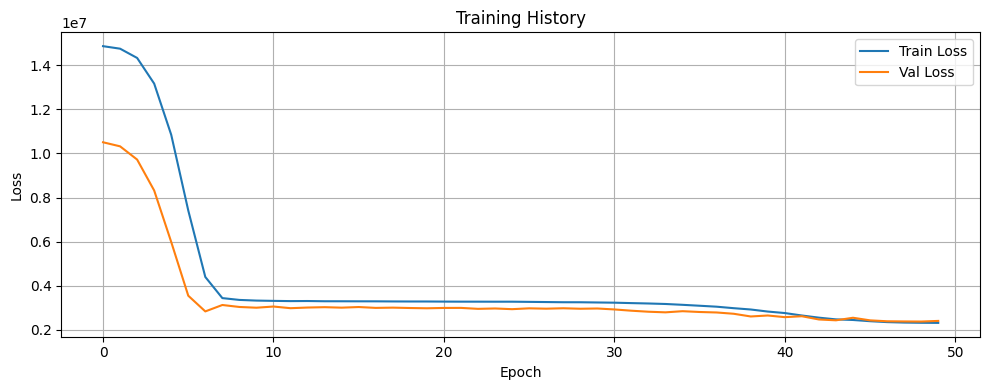

In [34]:
#  training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


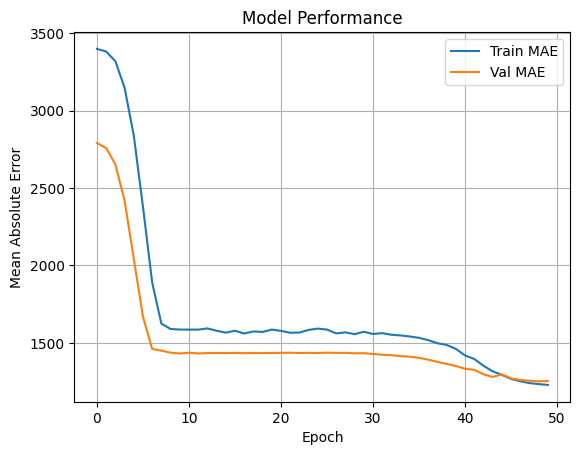

In [35]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance')
plt.legend()
plt.grid(True)
plt.show()

#### One day ahead forecast errors

In [36]:
# Predict on validation
y_pred = model.predict(val_inputs)

# Evaluate on t+1 forecast
y_true_t1 = y_val["target_t+1"].values
y_pred_t1 = y_pred[:, 0]

mae = mean_absolute_error(y_true_t1, y_pred_t1)
rmse = mean_squared_error(y_true_t1, y_pred_t1)

print(f"Mean Absolute Error (t+1): {mae:.2f}")
print(f"Root Mean Squared Error (t+1): {rmse:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Mean Absolute Error (t+1): 1301.45
Root Mean Squared Error (t+1): 2343487.78


#### 7 day forecast for 2 random days

In [37]:
import random

def forecast_prediction(y_true_df, y_pred_array, date_index, forecast_day_idx=None):
    if forecast_day_idx is None:
        forecast_day_idx = random.randint(0, len(y_true_df) - 1)
    
    future_days = range(1, 8)
    true_vals = [y_true_df[f'target_t+{i}'].iloc[forecast_day_idx] for i in future_days]
    pred_vals = y_pred_array[forecast_day_idx, :]

    base_date = pd.to_datetime(df.loc[y_true_df.index[forecast_day_idx], 'date'])
    future_dates = [base_date + pd.Timedelta(days=i) for i in future_days]


    plt.figure(figsize=(8, 4))
    plt.plot(future_dates, true_vals, marker='o', label='Actual')
    plt.plot(future_dates, pred_vals, marker='x', label='Predicted')
    plt.title(f"7-Day Forecast from {base_date.date()}")
    plt.xlabel("Date")
    plt.ylabel("Violations")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Forecast day index: {forecast_day_idx} | Forecast start date: {base_date.date()}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


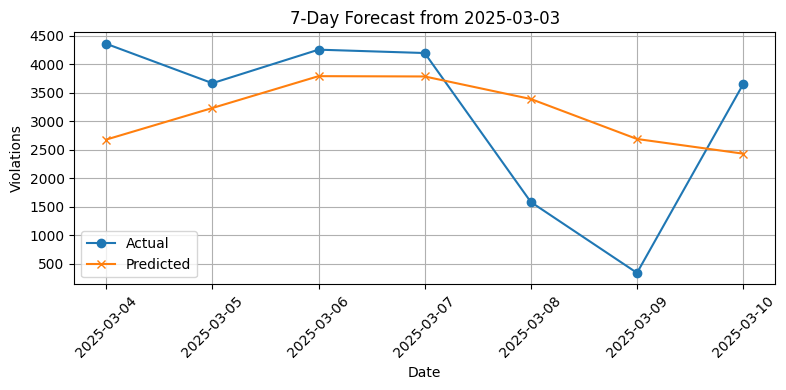

Forecast day index: 86 | Forecast start date: 2025-03-03


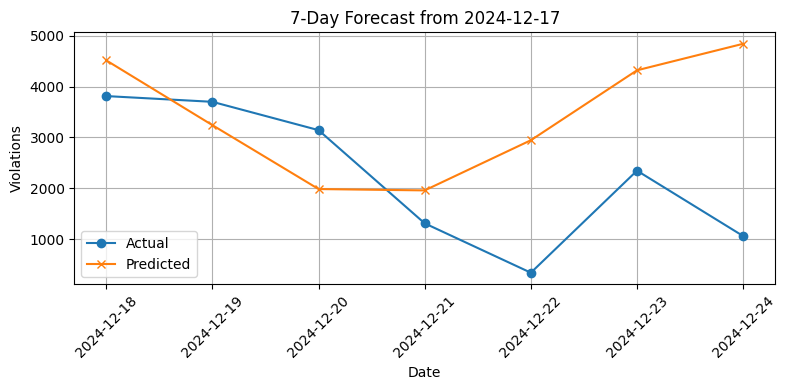

Forecast day index: 10 | Forecast start date: 2024-12-17


In [38]:
y_pred = model.predict(val_inputs)

forecast_prediction(y_val, y_pred, X_val.index)

forecast_prediction(y_val, y_pred, X_val.index, forecast_day_idx=10)


#### Predicted vs actual 3 day prediction for the first 30 days of the validation set

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


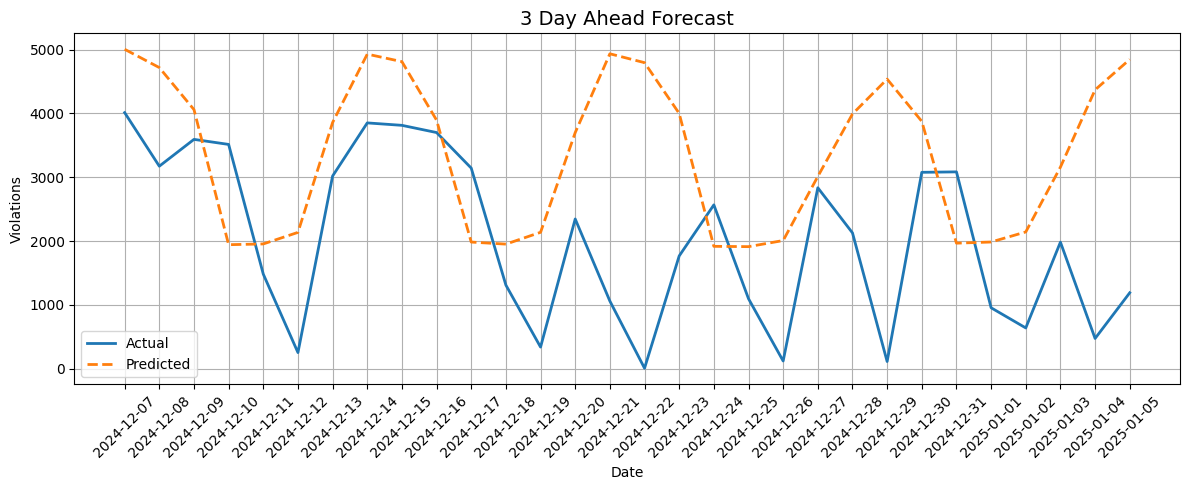

In [39]:
y_pred = model.predict(val_inputs)
dates = df.loc[X_val.index, 'date']

n = 30 
plt.figure(figsize=(12, 5))
plt.plot(dates[:n], y_val['target_t+3'].values[:n], label="Actual", linewidth=2)
plt.plot(dates[:n], y_pred[:n, 2], label="Predicted", linestyle='--', linewidth=2)
plt.title("3 Day Ahead Forecast", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Violations")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()